In [90]:
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
import random



In [125]:
data1 = pd.read_csv('data/01/1_raw_data_13-12_22.03.16.txt', sep="\s+")
data2 = pd.read_csv('data/01/2_raw_data_13-13_22.03.16.txt', sep="\s+")

# test_subj = random.randint(2, 36)
# f"{test_subj:02d}""
test_data =  pd.read_csv(f"data/12/1_raw_data_11-35_28.03.16.txt", sep="\s+")

print(len(data1), len(data2))
data = data1.append(data2, ignore_index=True)
data.head()


63196 57974


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0


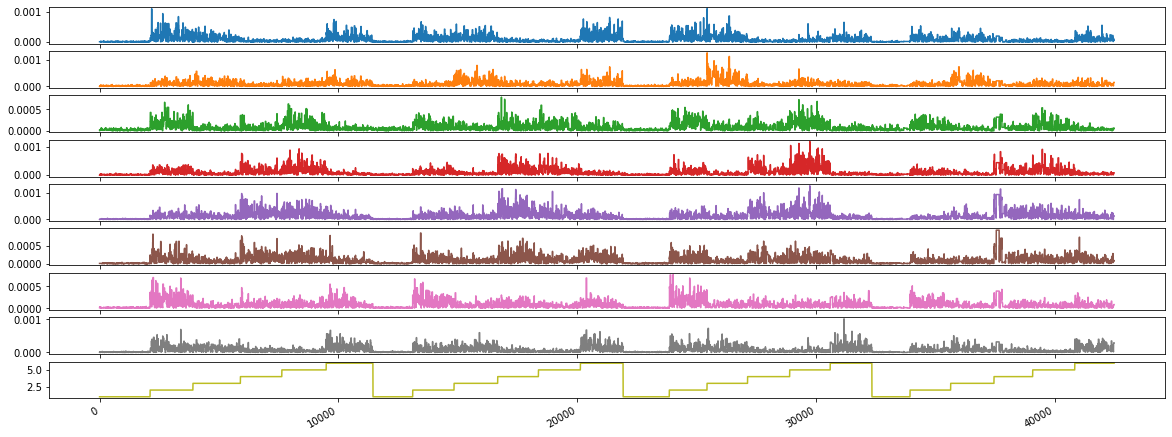

In [163]:
n_chans = 8
ch_names = []
for i in range(n_chans):
    ch_name = 'channel' + str(i+1)
    ch_names.append(ch_name)

meaning_cols = ch_names.copy()
meaning_cols.append('class')
data = data[meaning_cols]

def plot_data(data):
    data.plot(subplots=True, legend=False, figsize=(20,8))
    pyplot.show()

plot_data(data)

classes = data["class"].unique()

# for c in classes:
#     class_values = data[data["class"] == c][ch_names]
#     abs_values = class_values.abs()
#     values = pd.concat([ 
#         class_values.mean().rename("Mean"), 
#         class_values.var().rename("Variance"),
#         abs_values.mean().rename("Abs Mean"),
#         abs_values.var().rename("Abs Variance")
#     ], axis=1)
#     print(f"Class {c}:\n {values} \n")    


It is reasonable to use an absolute value of the signal. 
Set of amplitudes looks unique and more or less persistent for each class (except the '0' class),   
  being the key source of information for time signals while not taking its time-nature into account. (the sign is meaningless out of the time context)  

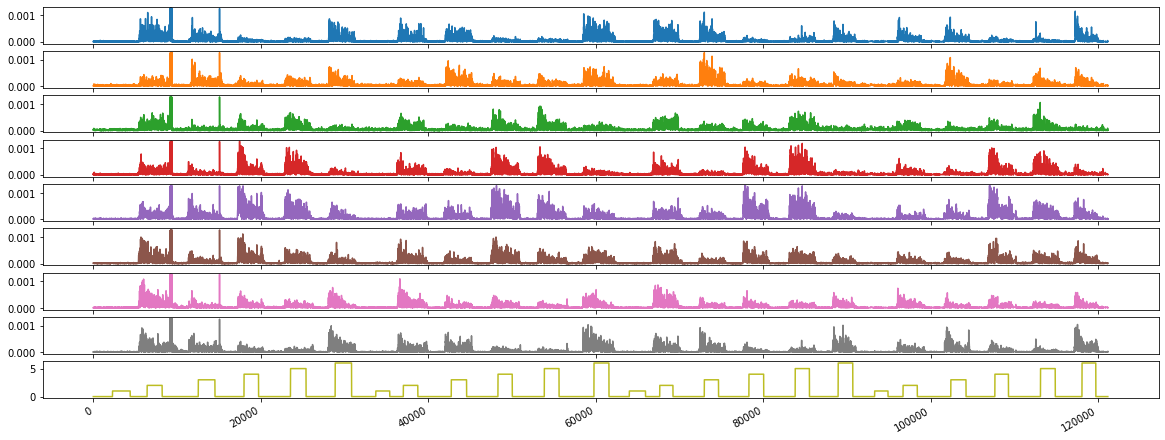

In [127]:
data = data.abs()

plot_data(data)

We can see here two clips on the first two active series within all the channels simultaneoulsly that look like artefacts or a hardware issues.
They rise maximum value that might slightly compresses a range of valid values and pollute statistics, so we discard them.

9160 0.0012699999999999999


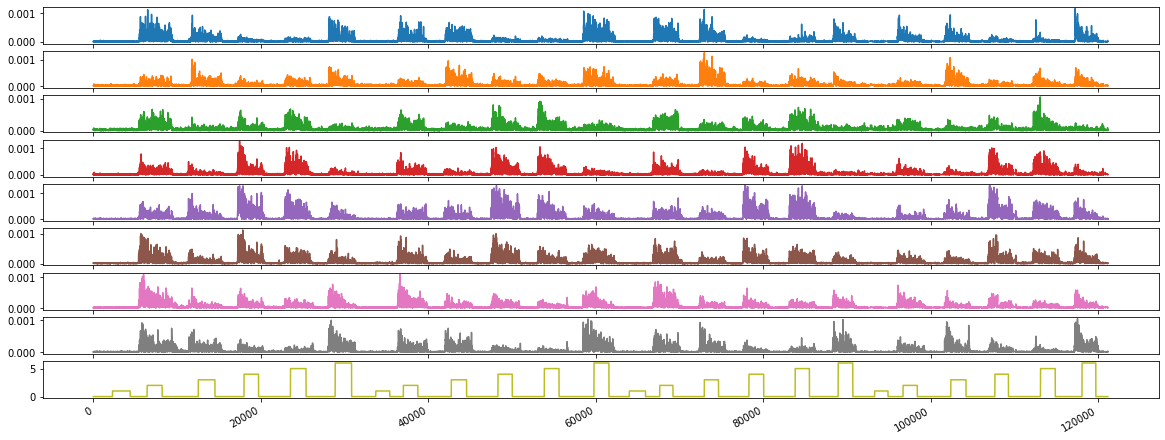

In [128]:
# using the channel3 as one with visually essential gap between clipping part and valid values
ch3 = data["channel3"]
max_val = max(ch3)
print(ch3.argmax(), max_val)

discarding_cells = ch3 < max_val*0.9
data = data[discarding_cells]
plot_data(data)


It is obvious from the visual data that class '0' is dominating, while others are more or less balanced We have ~120 000 samples so it's ok to undersample it.

In [129]:
sm = 0
for cls in classes:
    l = len(data[data["class"] == cls])
    print(f"{int(cls)}: {l}")
    if cls != 0: sm += l
mean_count = int( sm/(len(classes) - 1) )  

class0_data = data[data["class"] == 0]
class0_data = resample(class0_data, n_samples=mean_count, replace=False, random_state=42)
balanced_data = pd.concat([ data[data["class"] != 0], class0_data ], ignore_index=True)

balanced_data.head(5)

0: 78620
1: 7311
2: 6806
3: 7329
4: 6824
5: 7075
6: 7143


,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,0.00001,0.00000,0.00001,0.00000,0.00000,0.00001,0.00001,0.00001,1.0
1,0.00001,0.00002,0.00000,0.00001,0.00001,0.00001,0.00003,0.00002,1.0
2,0.00001,0.00002,0.00000,0.00001,0.00001,0.00001,0.00003,0.00002,1.0
3,0.00001,0.00002,0.00000,0.00001,0.00001,0.00001,0.00003,0.00002,1.0
4,0.00001,0.00002,0.00000,0.00001,0.00001,0.00001,0.00003,0.00002,1.0


In [227]:
def split_train(X, Y, test_size=0.15):
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=test_size)
    return (train_X, train_Y), (test_X, test_Y)

scaler = StandardScaler()

def scale_data(train, test):
    global scaler
    train_X = scaler.fit_transform(train[0])
    test_X = scaler.transform(test[0])
    return (train_X, train[1]), (test_X, test[1])

def test_classifier(c, test_X, test_Y):
    pred_Y = c.predict(test_X)
    
    report = classification_report(test_Y, pred_Y)
    cm = confusion_matrix(test_Y, pred_Y)
    print(report)
    print( 'Confusion matrix:\n {}'.format(cm) )

def train_logistic_regression(train_X, train_Y):
    c = LogisticRegression(random_state = 42, max_iter=2000)
    c.fit(train_X, train_Y)
    return c

In [131]:

train, test = split_train(balanced_data[ch_names], balanced_data["class"])
train, test = scale_data(train, test)
c1 = train_logistic_regression(*train)
test_classifier(c1, *test)

              precision    recall  f1-score   support

         0.0       0.13      0.11      0.12      1034
         1.0       0.63      0.97      0.76      1078
         2.0       0.69      0.62      0.65      1011
         3.0       0.64      0.58      0.61      1121
         4.0       0.54      0.54      0.54      1025
         5.0       0.61      0.54      0.57      1075
         6.0       0.54      0.48      0.51      1092

    accuracy                           0.55      7436
   macro avg       0.54      0.55      0.54      7436
weighted avg       0.54      0.55      0.54      7436

Confusion matrix:
 [[ 115  602   59   54   89   52   63]
 [  30 1048    0    0    0    0    0]
 [  93    1  628   17   47   86  139]
 [ 163    9   28  651   46    6  218]
 [ 172    4   37   42  549  209   12]
 [ 145    5   52   33  245  576   19]
 [ 187    1  107  223   33   15  526]]


Not the best accuracy. Let's look at the class descriptions. The class '0' is labled as "unmarked data", which explains why it has many false positives.
We actually should discard it.

In [142]:
data = data[data["class"] != 0] #.reset_index()

train, test = split_train(data[ch_names], data["class"])
train, test = scale_data(train, test)

c1 = train_logistic_regression(*train)
test_classifier(c1, *test)

              precision    recall  f1-score   support

         1.0       0.92      0.99      0.95      1093
         2.0       0.67      0.63      0.65       976
         3.0       0.64      0.62      0.63      1153
         4.0       0.54      0.62      0.58       958
         5.0       0.64      0.59      0.61      1084
         6.0       0.52      0.49      0.51      1110

    accuracy                           0.66      6374
   macro avg       0.65      0.66      0.65      6374
weighted avg       0.66      0.66      0.66      6374

Confusion matrix:
 [[1080    0    2    3    8    0]
 [   5  619   24   63   99  166]
 [  39   35  714   83   19  263]
 [  27   41   40  594  209   47]
 [  11   64   49  290  640   30]
 [   8  165  285   75   30  547]]


Accuracy increased to ~0,65! Better than coin but not the best.
We can see many false detections, especially between 4 and 5 classes, which goes for 
  "wrist extension" and "radial deviations" correspondingly. 
Also there is a big amount of cross-wrong predictions between 3 and 6 that correspond to
  "wrist flexion"  and  "ulnar deviations".

Whilest we know that our model is not perfect, these cross-disclassifications could be explaind
 from the position that subject uses quite similar set of muscles and therefore signals for gestures in each pair.

----
#### Alternatives
SVM classifier might work better on this type of data for several reasons.
It separates data based on it's geometrical properties, and we have 8d amplitude points that should concentrate in class-related clusters with specific shapes.
SVM is less sensetive to outliers, which we have some because the signal value always passes through zero line.
It also less vulnarable to overfitting which we'll check on test_data from another session.

In [228]:
def train_SVM(train_X, train_Y):
    #c = LinearSVC()
    c = SVC(decision_function_shape='ovr',random_state = 42, kernel='linear') # 'rbf'
    c.fit(train_X, train_Y)
    return c
    

In [145]:
c2 = train_SVM(*train)
test_classifier(c2, *test)


              precision    recall  f1-score   support

         1.0       0.94      1.00      0.97      1093
         2.0       0.84      0.78      0.81       976
         3.0       0.75      0.73      0.74      1153
         4.0       0.66      0.77      0.71       958
         5.0       0.75      0.66      0.70      1084
         6.0       0.68      0.68      0.68      1110

    accuracy                           0.77      6374
   macro avg       0.77      0.77      0.77      6374
weighted avg       0.77      0.77      0.77      6374

Confusion matrix:
 [[1088    0    0    3    2    0]
 [   2  763    7   24   58  122]
 [  25   27  837   50   16  198]
 [  19   32   17  734  134   22]
 [   9   33   35  270  718   19]
 [   9   52  221   38   32  758]]


Accuracy ~0.78 is much better. 

----
Let's test classifiers on the other subject's data

In [137]:
test_data = test_data.abs()[test_data["class"] != 0] #.reset_index()

#train, test = scale_data((data[ch_names], data["class"]), (test_data[ch_names], test_data["class"]))
#c1 = train_logistic_regression(*train)
#c2 = train_SVM(*train)

# testing on the learned classifiers we have
test = (scaler.transform(test_data[ch_names]), test_data["class"])

test_classifier(c1, *test)
test_classifier(c2, *test)


              precision    recall  f1-score   support

         1.0       0.95      1.00      0.98      3537
         2.0       0.50      0.28      0.35      3487
         3.0       0.16      0.15      0.15      3543
         4.0       0.57      0.73      0.64      3650
         5.0       0.42      0.35      0.38      3888
         6.0       0.41      0.57      0.48      3632

    accuracy                           0.51     21737
   macro avg       0.50      0.51      0.50     21737
weighted avg       0.50      0.51      0.50     21737

Confusion matrix:
 [[3526    0   11    0    0    0]
 [  88  960  454  302 1362  321]
 [   1  447  518   60   20 2497]
 [   1  309  154 2658  446   82]
 [   5   70 1763  622 1343   85]
 [  72  146  315 1005   13 2081]]
              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97      3537
         2.0       0.40      0.39      0.39      3487
         3.0       0.19      0.15      0.17      3543
         4.0       0.4

Apparently, we need to fit our models on a different sessions and different subjects to extract the common features and not overfit model with subject's uniqueness.
LR looks more stable in results for a another subject's data.

---
##### Extending features
Considering data to be a time series, let's extend features with a lag and some computed values using rolling window

In [264]:
# values choosen in the series of experiment. log size doesn't seem to bring much value
lag_size = 3
window_size = 100

feature_names = []

def extend_with_time_features(data):    
    fn_names = ["mean", "var", "std", "min", "max", "cov"] #, "corr", "skew", "kurt"]
    aggr_arg = {}
    fn_feature_names = []
    for ch in ch_names:
        for fn in fn_names:
            feature_name = f"{ch}_{fn}"
            fn_feature_names.append(feature_name)
            aggr_arg[feature_name] = fn
            
    lag_feature_names = []
    for i in range(0, lag_size):
        lag_feature_names = lag_feature_names + [f"{n}-{i}" for n in ch_names]
        
    global feature_names
    feature_names = fn_feature_names + lag_feature_names
    
    cls_dfs = []
    for cls in data["class"].unique():
        cls_dfs.append(data[data["class"] == cls].reset_index())
    
    # The number of windows that will include values 
    #     from the different session on the same class is tiny and acceptable
    ext_cls_dfs = []
    for df in cls_dfs:
        ext_df = pd.DataFrame(df["class"])
        for ch in ch_names:
            for fn in fn_names:
                feature_name = f"{ch}_{fn}"
                ext_df[feature_name] = df[ch]
        ext_df[fn_feature_names] = ext_df.rolling(window_size, min_periods=1).agg(aggr_arg)
        
        for i in range(0, lag_size):
            lag_names = [f"{n}-{i}" for n in ch_names]
            ext_df[lag_names] = df[ch_names].shift(i)
        
        ext_cls_dfs.append(ext_df)

    # TODO: understand pd groupping
    # windowed_data[fn_feature_names] = \
    #    windowed_data.groupby(data["class"].values).rolling(window_size).agg(aggr_arg)[fn_feature_names]

    return pd.concat(ext_cls_dfs, ignore_index=True).dropna()


In [265]:
ext_data = extend_with_time_features(data)

train, test = split_train(ext_data[feature_names], ext_data["class"])

train, test = scale_data(train, test)
c3 = train_logistic_regression(*train)
#c4 = train_SVM(*train)


test_classifier(c3, *test)
#test_classifier(c4, *test)


              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1113
         2.0       1.00      1.00      1.00      1046
         3.0       0.95      0.96      0.96      1059
         4.0       0.93      0.94      0.93      1024
         5.0       0.95      0.93      0.94      1085
         6.0       0.96      0.95      0.96      1045

    accuracy                           0.96      6372
   macro avg       0.96      0.96      0.96      6372
weighted avg       0.96      0.96      0.96      6372

Confusion matrix:
 [[1113    0    0    0    0    0]
 [   0 1046    0    0    0    0]
 [   0    0 1021    0    0   38]
 [   0    0    0  966   58    0]
 [   0    0    1   78 1006    0]
 [   0    0   50    0    0  995]]


In [266]:
# test on another subject data
ext_test_data = extend_with_time_features(test_data)

test = (scaler.transform(ext_test_data[feature_names]), ext_test_data["class"])
train, test = scale_data(train, test)

test_classifier(c3, *test)
#test_classifier(c4, *test)


              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00      3535
         2.0       0.94      0.55      0.69      3485
         3.0       0.00      0.00      0.00      3541
         4.0       0.80      0.96      0.87      3648
         5.0       0.63      0.67      0.65      3886
         6.0       0.47      0.88      0.61      3630

    accuracy                           0.68     21725
   macro avg       0.64      0.68      0.64     21725
weighted avg       0.64      0.68      0.64     21725

Confusion matrix:
 [[3535    0    0    0    0    0]
 [  18 1912   11   39 1505    0]
 [   0    0    0    0    0 3541]
 [   0  116    0 3492   37    3]
 [   0    0  914  359 2611    2]
 [   3    0    0  450    0 3177]]


Accuracy increased! On the same-subject set it reaches 0.96, while on another subject's dats it lifted to 0.68, which is not so bad.
We still see '4'-'5' and '3'-'6' classes conflicts, which might be triggerd by phisiological features (also new '5'-'2' conflict for subject 2, which also speaks in favor of this point).
Though, further feature tuning and research is possible. 

Unfortunately, SVM accuracy on the extended features is not much better than LG, while it is much slower.

In [267]:
# NEXT TODO:
# - Extract more features from time window: variance, mean, lag features  -- DONE
# - Tune extracted features, use original signal
# - Do PCAnalysis + plot clasters in 3d max valued feature
# - FFT, build spectrogram
# - Try deep learning classifier with LSTM
# Tune parameters - SVN kernel
# ?add cross validation, think on samples